In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import data
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
def visualize_results(X, Y, Y_, func, special=[], title=None):
    bbox = (np.min(X, axis=0), np.max(X, axis=0))
    xmin, ymin = bbox[0]
    xmax, ymax = bbox[1]
    
    plt.figure(figsize=(10, 10))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    if title is not None:
        plt.title(title)
    
    data.graph_surface(func, bbox)
    data.graph_data(X, Y_, Y, special=special)
    plt.show()

### 1. Generiranje linearno nerazdvojivih podataka

In [3]:
# todo: graph_surface & graph_data

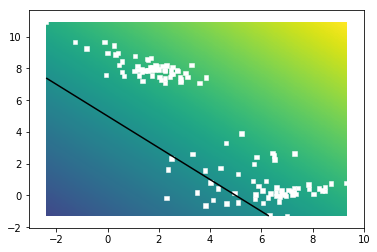

In [26]:
X, Y_ = data.sample_gmm(4, 2, 30)

bbox = (np.min(X, axis=0), np.max(X, axis=0))
data.graph_surface(data.myDummyDecision, bbox, offset=0)
data.graph_data(X, Y_, data.myDummyDecision(X))
plt.show()

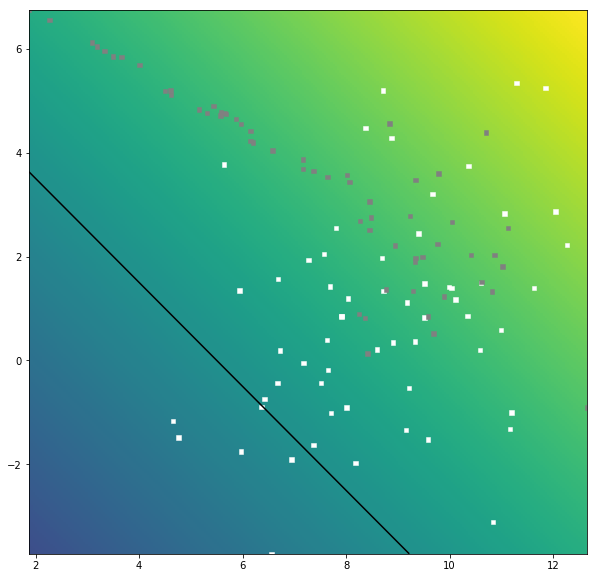

In [3]:
X, Y_ = data.sample_gmm(4, 2, 30)

visualize_results(X, data.myDummyDecision(X), Y_, data.myDummyDecision)

### 2. Višeslojna klasifikacija u Pythonu

In [4]:
def fcann2_train(X, Y_, hidden_size=2, param_delta=0.5, param_niter=10000, verbose=False, print_every=1000):
    Yoh_ = data.class_to_onehot(Y_)
    
    N = X.shape[0]
    input_size = X.shape[1]
    output_size = Yoh_.shape[1]

    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    for i in range(param_niter):
        h1, h2, probs = fcann2_forward(X, W1, b1, W2, b2)
        
        if verbose and i % print_every == 0:
            val = -np.log(probs) * Yoh_
            loss = np.sum(val) / N
            print(i, loss)
            
        # grad softmax
        dscores = probs
        dscores[range(N), Y_] -= 1
        dscores /= N

        # grad last layer
        grad_W2 = np.dot(h1.T, dscores)
        grad_b2 = np.sum(dscores, axis=0)

        # grad trough relu
        grad_relu = np.dot(dscores, W2.T)
        grad_relu[h1 <= 0] = 0

        # grad first layer
        grad_W1 = np.dot(X.T, grad_relu)
        grad_b1 = np.sum(grad_relu, axis=0)

        W2 += -param_delta * grad_W2
        b2 += -param_delta * grad_b2
        W1 += -param_delta * grad_W1
        b1 += -param_delta * grad_b1

    return W2, b2, W1, b1

def fcann2_forward(X, W1, b1, W2, b2):
    h1 = np.dot(X, W1) + b1
    h1[h1 <= 0] = 0
    scores = h1.dot(W2) + b2
    probs = np.exp(scores) / (1 + np.exp(scores))
    return h1, scores, probs

0 0.465202162898
1000 0.0509262132463
2000 0.0498213016399
3000 0.0494384407187
4000 0.0492617230979
5000 0.0491699615657
6000 0.0491336996371
7000 0.0495262158219
8000 0.0491736426656
9000 0.00592782024726


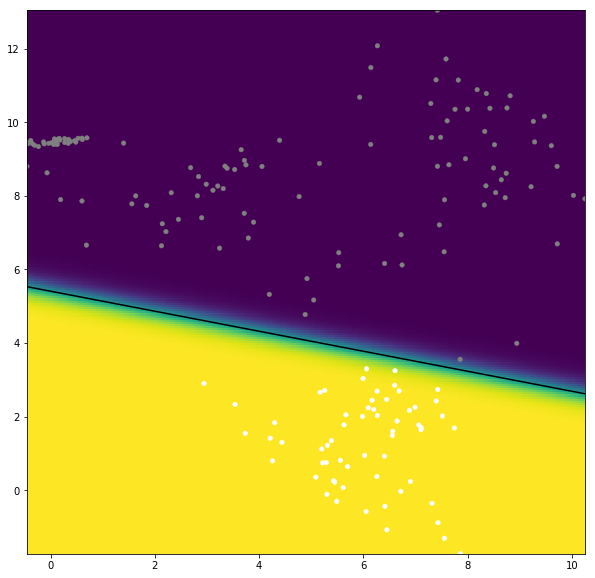

In [44]:
# np.random.seed(505)

verbose = True
print_every = 1000
K = 6
C = 2
N = 30
hidden_size = 2
param_delta = 0.5
param_niter = 10000

X, Y_ = data.sample_gmm(K, C, N)

W2, b2, W1, b1 = fcann2_train(X, Y_, hidden_size, param_delta, param_niter, verbose, print_every)

def predict_c1_class(W1, b1, W2, b2):
    def classify(X):
        return fcann2_forward(X, W1, b1, W2, b2)[2][:,1]
    return classify

decfun = predict_c1_class(W1, b1, W2, b2)

probs = decfun(X)
Y = probs > 0.5

visualize_results(X, Y, Y_, decfun)

### 3. Linearna regresija u Tensorflowu

In [9]:
## 1. definicija računskog grafa
# podatci i parametri
X  = tf.placeholder(tf.float32, [None])
Y_ = tf.placeholder(tf.float32, [None])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# afini regresijski model
Y = a * X + b

# kvadratni gubitak
loss = (Y - Y_)**2

# optimizacijski postupak: gradijentni spust
trainer = tf.train.GradientDescentOptimizer(0.1)

# train_op = trainer.minimize(loss) # isto kao sljedeca dva reda
grads_and_vars = trainer.compute_gradients(loss)
grads = list(filter(lambda x: x is not None, [grad for grad, var in grads_and_vars]))
train_op = trainer.apply_gradients(grads_and_vars)

## 2. inicijalizacija parametara
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## 3. učenje
# neka igre počnu!
for i in range(100):
    val_loss, _, val_a, val_b = sess.run([loss, train_op, a, b], 
        feed_dict={X: [1,2], Y_: [3,5]})
    
    val_grads = sess.run(grads, feed_dict={X: [1,2], Y_: [3,5]})
    
    if i % 10 == 0:
        print('i: {}\tloss: {}\ta: {:.2f}\tb: {:.2f}\tgrads: {}'.format(i, val_loss, val_a, val_b, val_grads))

i: 0	loss: [  9.  25.]	a: 2.60	b: 1.60	grads: [9.6000013, 6.000001]
i: 10	loss: [ 0.00233997  0.000914  ]	a: 1.92	b: 1.12	grads: [-0.021769524, 0.036278725]
i: 20	loss: [ 0.00130224  0.00049741]	a: 1.94	b: 1.09	grads: [-0.016540527, 0.026762962]
i: 30	loss: [ 0.0007202   0.00027511]	a: 1.96	b: 1.07	grads: [-0.012299538, 0.019904137]
i: 40	loss: [ 0.00039833  0.00015215]	a: 1.97	b: 1.05	grads: [-0.009147644, 0.014801979]
i: 50	loss: [  2.20300106e-04   8.41511428e-05]	a: 1.98	b: 1.04	grads: [-0.0068025589, 0.011008263]
i: 60	loss: [  1.21844139e-04   4.65411758e-05]	a: 1.98	b: 1.03	grads: [-0.0050611496, 0.0081853867]
i: 70	loss: [  6.73914328e-05   2.57360443e-05]	a: 1.99	b: 1.02	grads: [-0.0037641525, 0.0060873032]
i: 80	loss: [  3.72703689e-05   1.42371318e-05]	a: 1.99	b: 1.02	grads: [-0.0027990341, 0.004527092]
i: 90	loss: [  2.06112963e-05   7.87468343e-06]	a: 1.99	b: 1.01	grads: [-0.0020813942, 0.0033669472]


### 4. Logistička regresija u Tensorflowu

In [10]:
class TFLogreg:
    def __init__(self, D, C, param_delta=0.1):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """

        # definicija podataka i parametara:
        # definirati self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float32, [None, D])
        self.Yoh_ = tf.placeholder(tf.float32, [None, C])
        self.W = tf.Variable(tf.random_normal([D, C]))
        self.b = tf.Variable(tf.random_normal([C]))

        # formulacija modela: izračunati self.probs
        #   koristiti: tf.matmul, tf.nn.softmax
        self.score = tf.matmul(self.X, self.W) + self.b
        self.probs = tf.nn.softmax(self.score)

        # formulacija gubitka: self.loss
        #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=1))
        # + param_lambda * tf.nn.l2_loss(self.W) # L2 regularizacija

        # formulacija operacije učenja: self.train_step
        #   koristiti: tf.train.GradientDescentOptimizer,
        #              tf.train.GradientDescentOptimizer.minimize
        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        
        # instanciranje izvedbenog konteksta: self.session
        #   koristiti: tf.Session
        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter, verbose=False, print_every=100):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        #   koristiti: tf.initialize_all_variables
        init = tf.global_variables_initializer()

        # optimizacijska petlja
        #   koristiti: tf.Session.run
        self.session.run(init)
        
        # Training cycle
        for i in range(param_niter):
            _, val_loss = self.session.run([self.optimizer, self.loss],
                                           feed_dict={self.X: X, self.Yoh_: Yoh_})
            
            if verbose and i % print_every == 0:
                print(i, val_loss)

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        
        return self.session.run(self.probs, feed_dict={self.X: X})
    
    def accuracy(self, X, Yoh_):
        correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.Yoh_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy.eval({self.X: X, self.Yoh_: Yoh_}, session=self.session)

0 0.213643
100 0.137791
200 0.129153
300 0.124814
400 0.122409
500 0.120982
600 0.120092
700 0.119517
800 0.119135
900 0.118876
Accuracy: 0.938889


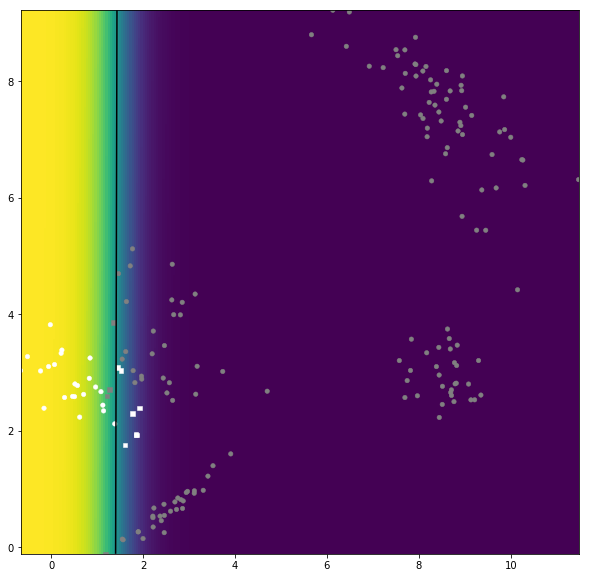

In [23]:
# inicijaliziraj generatore slučajnih brojeva
# tf.set_random_seed(100)
np.random.seed(505)

verbose = True
print_every = 100
dim = 2
K = 6
C = 2
N = 30
param_delta = 0.5
param_niter = 1000

# instanciraj podatke X i labele Yoh_
X, Y_ = data.sample_gmm(K, C, N)
Yoh_ = data.class_to_onehot(Y_)

# izgradi graf:
tflr = TFLogreg(dim, C, param_delta)

# nauči parametre:
tflr.train(X, Yoh_, param_niter, verbose, print_every)

# dohvati vjerojatnosti na skupu za učenje
probs = tflr.eval(X)
Y = probs[:,1] > 0.5

# ispiši performansu (preciznost i odziv po razredima)
# Test model
print('Accuracy:', tflr.accuracy(X, Yoh_))

# iscrtaj rezultate, decizijsku plohu
def predict_c1_class(tflr):
    def classify(X):
        return tflr.eval(X)[:,1]
    return classify

decfun = predict_c1_class(tflr)
visualize_results(X, Y, Y_, decfun)

### 5. Konfigurabilni duboki modeli u Tensorflowu

In [11]:
# todo: debug, simbolicka imena

In [106]:
class TFDeep:
    def __init__(self, layers, param_delta=0.1, activation=tf.nn.relu):
        self.X = tf.placeholder(tf.float32, [None, layers[0]])
        self.Yoh_ = tf.placeholder(tf.float32, [None, layers[-1]])
        self.W = []
        self.b = []
        
        prev = layers[0]
        out = self.X
        for dim in layers[1:-1]:
            temp_W = tf.Variable(tf.random_normal([prev, dim]))
            temp_b = tf.Variable(tf.random_normal([dim]))                
            self.W.append(temp_W)
            self.b.append(temp_b)
            
            out = tf.matmul(out, temp_W) + temp_b
            out = activation(out)
            
            prev = dim
        
        temp_W = tf.Variable(tf.random_normal([prev, layers[-1]]))
        temp_b = tf.Variable(tf.random_normal([layers[-1]]))
        self.W.append(temp_W)
        self.b.append(temp_b)
        
        self.last_layer_w = self.W
        
        self.probs = tf.nn.softmax(tf.matmul(out, temp_W) + temp_b)
        
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=1))

        self.trainer = tf.train.GradientDescentOptimizer(param_delta)
        self.optimizer = self.trainer.minimize(self.loss)
        
        self.session = tf.Session()
    
    def train(self, X, Yoh_, param_niter, batch_size, verbose=False, print_every=100):
        init = tf.global_variables_initializer()
        self.session.run(init)
        
        nr_batches = int(X.shape[0] / batch_size)
        
        for i in range(nr_batches):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size
            
            batch_X = X[batch_start:batch_end]
            batch_Yoh_ = Yoh_[batch_start:batch_end]
        
            for j in range(param_niter):
                _, val_loss = self.session.run([self.optimizer, self.loss],
                                               feed_dict={self.X: batch_X, self.Yoh_: batch_Yoh_})

                if verbose and j % print_every == 0:
                    print('Batch: {}\tIteration: {}\tLoss: {}'.format(i, j, val_loss))
    
    def eval(self, X):
        return self.session.run(self.probs, feed_dict={self.X: X})
    
    def accuracy(self, X, Yoh_):
        correct_prediction = tf.equal(tf.argmax(self.probs, 1), tf.argmax(self.Yoh_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy.eval({self.X: X, self.Yoh_: Yoh_}, session=self.session)

In [46]:
np.random.seed(1000)

verbose = True
print_every = 1000
dim = 2
K = 6
C = 2
N = 10
param_delta = 0.05
param_niter = 10000
layers = [dim, 10, 10, C]

X, Y_ = data.sample_gmm(K, C, N)
Yoh_ = data.class_to_onehot(Y_)

def predict_c1_class(tfdeep):
    def classify(X):
        return tfdeep.eval(X)[:,1]
    return classify

0 1.27291
1000 0.292766
2000 0.205787
3000 0.185695
4000 0.176619
5000 0.171335
6000 0.167603
7000 0.164639
8000 0.161182
9000 0.149668
Accuracy: 0.95


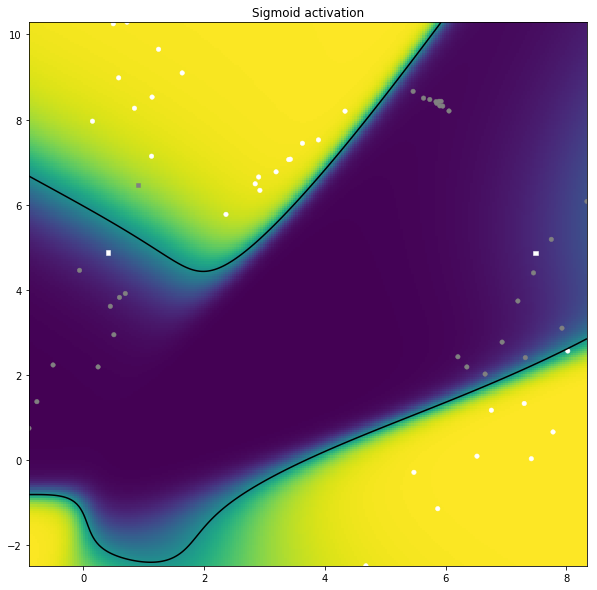

In [48]:
tfdeep = TFDeep(layers, param_delta, activation=tf.nn.sigmoid)

tfdeep.train(X, Yoh_, param_niter, verbose, print_every)

probs = tfdeep.eval(X)
Y = probs[:,1] > 0.5

print('Accuracy:', tfdeep.accuracy(X, Yoh_))

decfun = predict_c1_class(tfdeep)
visualize_results(X, Y, Y_, decfun, title='Sigmoid activation')

0 14.4537
1000 0.183568
2000 0.137368
3000 0.119276
4000 0.106251
5000 0.102245
6000 0.101757
7000 0.0838618
8000 0.074468
9000 0.0716129
Accuracy: 0.966667


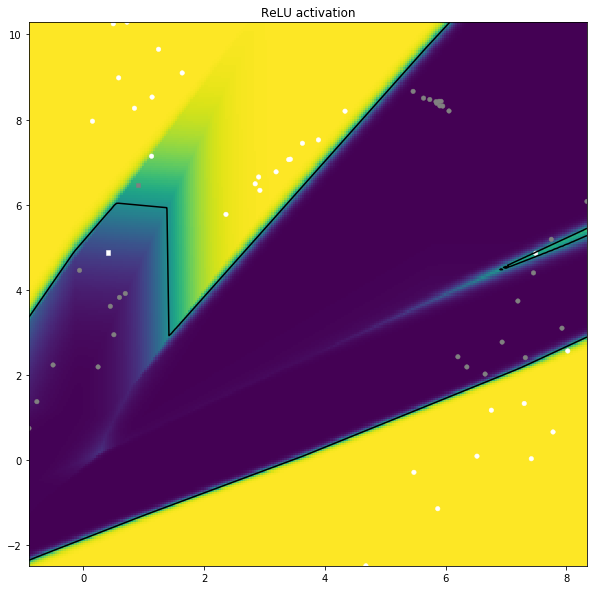

In [50]:
tfdeep = TFDeep(layers, param_delta, activation=tf.nn.relu)

tfdeep.train(X, Yoh_, param_niter, verbose, print_every)

probs = tfdeep.eval(X)
Y = probs[:,1] > 0.5

print('Accuracy:', tfdeep.accuracy(X, Yoh_))

decfun = predict_c1_class(tfdeep)
visualize_results(X, Y, Y_, decfun, title='ReLU activation')

In [ ]:
tfdeep = TFDeep(layers, param_delta, activation=tf.nn.sigmoid)

tfdeep.train(X, Yoh_, param_niter, verbose, print_every)

probs = tfdeep.eval(X)
Y = probs[:,1] > 0.5

print('Accuracy:', tfdeep.accuracy(X, Yoh_))

decfun = predict_c1_class(tfdeep)
visualize_results(X, Y, Y_, decfun)
plt.title('Sigmoid activation')

### 6. Usporedba s jezgrenim SVM-om

In [40]:
class KSVMWrap:
    def __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
        """
            Konstruira omotač i uči RBF SVM klasifikator
            X,Y_:            podatci i točni indeksi razreda
            param_svm_c:     relativni značaj podatkovne cijene
            param_svm_gamma: širina RBF jezgre
        """
        self.model = svm.SVC(C=param_svm_c, gamma=param_svm_gamma, probability=True)
        self.model.fit(X, Y_)

    def predict(self, X):
        """
            Predviđa i vraća indekse razreda podataka X
        """
        return self.model.fit(X, Y_)

    def scores(self, X):
        """
            Vraća klasifikacijske mjere podataka X
        """
        return self.model.predict_proba(X)

    def support(self):
        """
            Indeksi podataka koji su odabrani za potporne vektore
        """
        return self.model.support_
    
    def accuracy(self, X, Y_):
        return self.model.score(X, Y_)

Accuracy: 0.933333333333


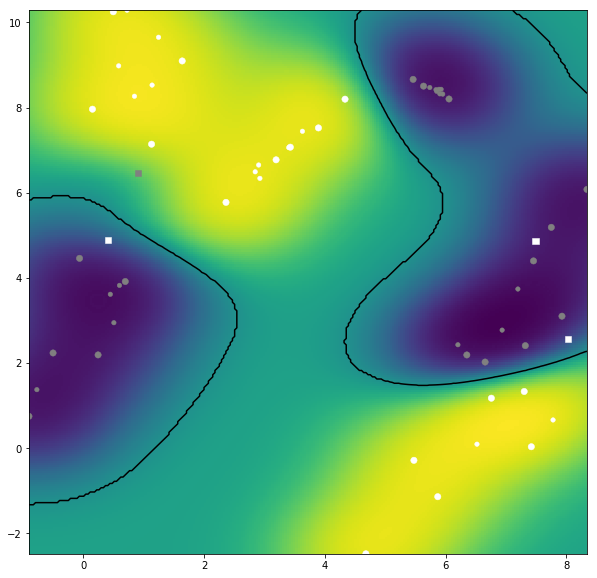

In [42]:
np.random.seed(1000)

K = 6
C = 2
N = 10
param_svm_c = 1
param_svm_gamma = 'auto'

X, Y_ = data.sample_gmm(K, C, N)

svm_wrap = KSVMWrap(X, Y_, param_svm_c, param_svm_gamma)

probs = svm_wrap.scores(X)
Y = probs[:,1] > 0.5

print('Accuracy:', svm_wrap.accuracy(X, Y_))

def predict_c1_class(svm_wrap):
    def classify(X):
        return svm_wrap.scores(X)[:,1]
    return classify

decfun = predict_c1_class(svm_wrap)
visualize_results(X, Y, Y_, decfun, special=svm_wrap.support())

### 7. Studija slučaja: MNIST

In [52]:
from tensorflow.examples.tutorials.mnist import input_data

tf.app.flags.DEFINE_string('data_dir', 
  '/tmp/data/', 'Directory for storing data')
mnist = input_data.read_data_sets(
  tf.app.flags.FLAGS.data_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [114]:
verbose = True
print_every = 5000
param_delta = 0.01
param_niter = 10000
layers = [784, 10]
batch_size = 1000

tfdeep = TFDeep(layers, param_delta)

tfdeep.train(mnist.train.images, mnist.train.labels, param_niter, batch_size, verbose, print_every)

print('Accuracy:', tfdeep.accuracy(mnist.train.images[:1000], mnist.train.labels[:1000]))

Batch: 0	Iteration: 0	Loss: 15.816658020019531
Batch: 0	Iteration: 5000	Loss: 0.8244914412498474
Batch: 1	Iteration: 0	Loss: 1.2081043720245361
Batch: 1	Iteration: 5000	Loss: 0.49483296275138855
Batch: 2	Iteration: 0	Loss: 1.0748858451843262
Batch: 2	Iteration: 5000	Loss: 0.47030767798423767
Batch: 3	Iteration: 0	Loss: 1.1545336246490479
Batch: 3	Iteration: 5000	Loss: 0.5228236317634583
Batch: 4	Iteration: 0	Loss: 0.8088874220848083
Batch: 4	Iteration: 5000	Loss: 0.33209356665611267
Batch: 5	Iteration: 0	Loss: 0.7271386981010437
Batch: 5	Iteration: 5000	Loss: 0.2910877764225006
Batch: 6	Iteration: 0	Loss: 0.7816759347915649
Batch: 6	Iteration: 5000	Loss: 0.3202938735485077
Batch: 7	Iteration: 0	Loss: 0.9841446876525879
Batch: 7	Iteration: 5000	Loss: 0.3562897741794586
Batch: 8	Iteration: 0	Loss: 0.9284448623657227
Batch: 8	Iteration: 5000	Loss: 0.4208639860153198
Batch: 9	Iteration: 0	Loss: 0.9650058746337891
Batch: 9	Iteration: 5000	Loss: 0.3632171154022217
Batch: 10	Iteration: 0	Loss

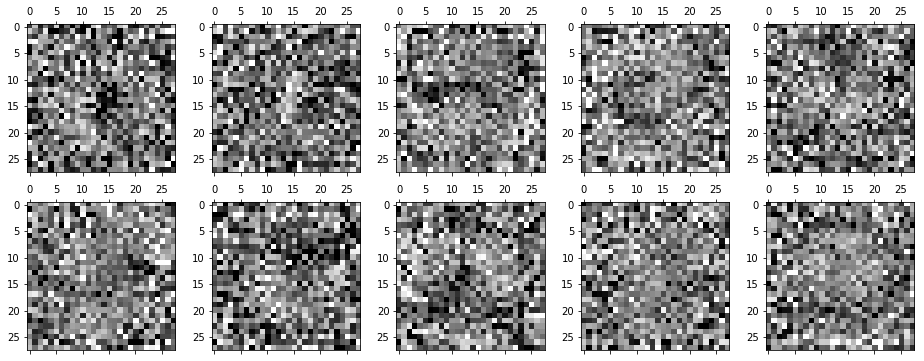

In [115]:
_, plots = plt.subplots(2, 5, figsize=(16, 6))
for i, plot in enumerate(plots.flatten()):
    vmin = tfdeep.session.run(tfdeep.last_layer_w)[0][:,i].min()
    vmax = tfdeep.session.run(tfdeep.last_layer_w)[0][:,0].max()
    plot.matshow(tfdeep.session.run(tfdeep.last_layer_w)[0][:,i].reshape(28,28),
                 cmap=plt.cm.gray, vmin=(0.5 * vmin), vmax=(0.5 * vmax))
plt.show()